
<h1><center>Detailed analysis of the fluid filling machine operation and detection of anomalies during the filling process <center></h1>
<h2><center>Case study of the Renault Traffic III<center></h2> 

<p><center>
    <img src="presentation/First slide.png" alt="drawing" style="width:300px"/>
    <img src="presentation/logo-renault-digital.jpg" alt="drawing" style="width:400px"/>
<center></p>
    
<h4><center> Alix Tiran-Cappello, 13th September 2021<center></h4> 

Try to understand this notebook and get inspiration for your slide-based presentation
- Click on `View-->Cell Toolbar-->SlideShow` to display Slide Types
- Click on `View-->Cell Toolbar-->Tags` to display Slide Tags

Then, generate an html-slide version of this using the following command:

```
jupyter nbconvert slide_like_a_pro.ipynb --to slides --post serve \
--no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output
```

- `no-prompt` removes the In [xx]: and Out[xx]: to the left of each cells
- `--TagRemovePreprocessor` allows you to not display either inputs or outputs of cells that have the associated Tag

In [1]:
# Skip these imports cells from displaying as slide
%load_ext autoreload
%autoreload 2
from renault.plot import plot_all_fluid, plot_fluids, plot_selective_fluid
from renault.get_data import get_most_important_types, get_pji_with_misssing_fluids_measure, datetime_reshaping
from renault.feature_engineering import feature_engineering
from renault.anomaly_detection import AnomalyDetection

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

In [2]:
COLUMN_NAMES = ['Unnamed: 0', 'siteCode', 
                'objectUAI', 'machine', 
                'fluid','measurement',
                'step', 'sourceTimestamp', 
                'pji', 'dataValue',
                'body_type', 'driving_side', 
                'gearbox_type', 'hybrid_level',
                'engine_type']

filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

In [39]:
# Actual data import
df = pd.read_csv('../data/final_df_ropit.csv',index_col='Unnamed: 0')

# Removes 'UTC' in the timestape and convert to DT
time = [t[:19] for t in df.sourceTimestamp]
time = pd.to_datetime(time, infer_datetime_format=True)
df['time'] = time

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Introduction

**Problematic:** Design a anomaly detection model to facilitate the identification for fluid filling failures at the end of the assembly line

**Outline:**

- Characterization the global structure of the data from the filling machine 

- Design an unsupervised anomaly detection algorithm

- Apply it to the case study of the Traffic III

# Organization of the data the in df_ropit dataset

## First step of data cleaning

- Removing the corrupted lines (~95) from original dataset
- Suppressing duplicated entries revealed an high number of repeated lines
- Conversion of the timestamps to date-time format

In [54]:
df.sample(3, random_state=3)

,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time
2507786,FRFluid,ActVacuum,StepVacuum1,2021-05-24 23:25:41 UTC,1411192,2,HJD,DG,BVM6,HYB01,K9K,2021-05-24 23:25:41
659042,RMFluid,ActVacuum,StepVacuum1,2021-05-14 19:28:52.487 UTC,2151393,31,HJD,DD,BVM6,HYB01,H4D,2021-05-14 19:28:52
222419,RMFluid,ActLoadingPressure,StepLoading,2021-05-12 07:11:40.887 UTC,2230423,185,BJI,DG,BVM6,HYB01,H4D,2021-05-12 07:11:40


## Example of typical filling process

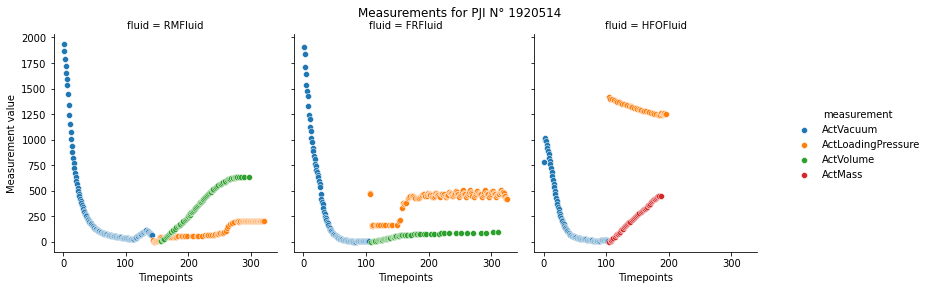

In [6]:
names = pd.Series(df.pji.unique())
plot_all_fluid(df, names.sample(1, random_state=41).values[0]);

## Analysis of the diversity of car type

In [7]:
top_cars = get_most_important_types(df, 10)
top_cars

,body_type,gearbox_type,engine_type,driving_side,hybrid_level,percentage_of_production
6,BJI,BVM6,H4D,DG,HYB01,23.011583
23,HJD,BVM6,K9K,DG,HYB01,21.389961
17,HJD,BVM6,H4D,DG,HYB01,14.851995
20,HJD,BVM6,H5H,DG,HYB01,6.280566
7,BJI,CVTX,H4D,DG,HYB01,4.427284
29,LJI,BVM6,H4D,DG,HYB01,4.015444
16,HJD,BVM6,H4D,DD,HYB01,3.963964
13,HJD,BVM5,H4M,DG,HYB01,3.449163
19,HJD,BVM6,H5H,DD,HYB01,2.651223
21,HJD,BVM6,K9K,DD,HYB01,2.342342


The main most produced type of car is a subtype of the Sandero III, but only by a small margin, the other main type is the Duster II.

## Impact of the car types on the filling process 

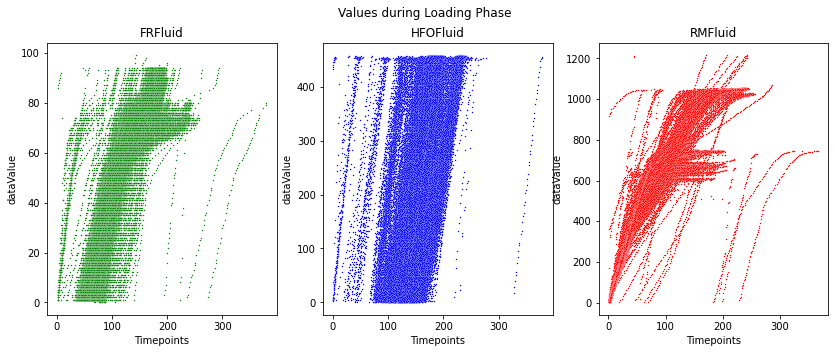

In [40]:
temp = df[df['measurement'].isin(filling)].copy()
temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby('pji').cumcount()+1

plot_fluids(temp, x='rk', y='dataValue', s=2)
plt.suptitle('Values during Loading Phase');

While HFOFluid filling and the car type are globally independent, the filling of FRFLuid and particularly RMFluid is extremely dependent on it, as it could be expected from the different volumes of engines.

## Analysis of the diversity within a given type

In [41]:
# Get a list of conditions to filter the 10 main types of cars
condition=[]
for line in range(top_cars.shape[0]):
    string = ''
    for idx in range(top_cars.shape[1]-1):
        string += f'{top_cars.columns[idx]} == "{top_cars.iloc[line, idx]}" & '
    condition.append(string[:-2])
    
condition[0:3]

['body_type == "BJI" & gearbox_type == "BVM6" & engine_type == "H4D" & driving_side == "DG" & hybrid_level == "HYB01" ',
 'body_type == "HJD" & gearbox_type == "BVM6" & engine_type == "K9K" & driving_side == "DG" & hybrid_level == "HYB01" ',
 'body_type == "HJD" & gearbox_type == "BVM6" & engine_type == "H4D" & driving_side == "DG" & hybrid_level == "HYB01" ']

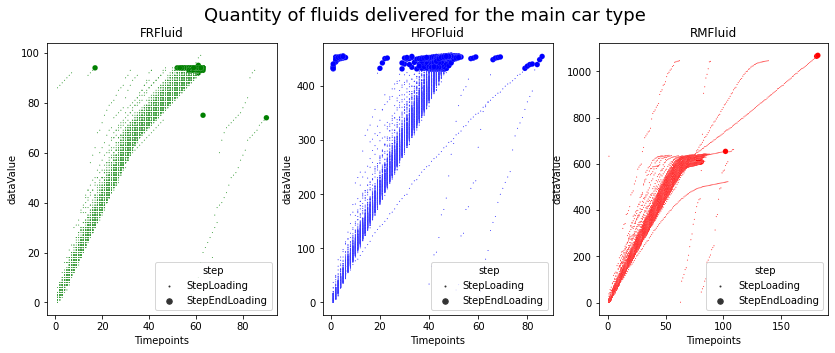

In [59]:
cond = condition[0]
temp = df[df.measurement.isin(filling)].query(cond).copy()
temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby(['pji', 'fluid']).cumcount()+1

plot_fluids(temp, x='rk', y='dataValue', size='step', sizes= (30, 1))
plt.suptitle(f'Quantity of fluids delivered for the main car type', size=18)
plt.show()

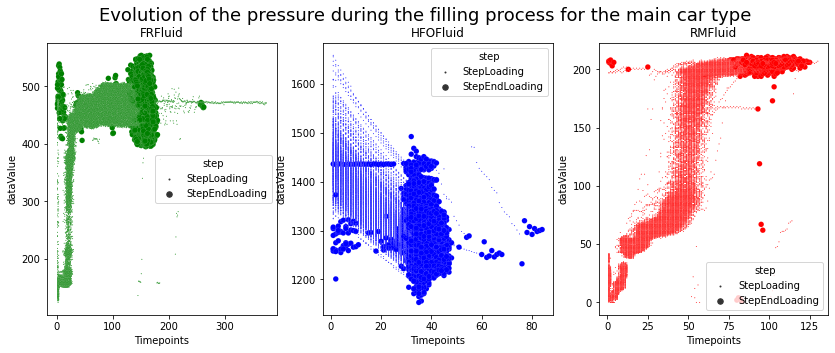

In [43]:
for cond in condition[:1]:
    temp = df[df.measurement == 'ActLoadingPressure'].query(cond).copy()
    temp.sort_values('sourceTimestamp', inplace=True)
    temp['rk'] = temp.groupby(['pji', 'fluid']).cumcount()+1

    plot_fluids(temp, x='rk', y='dataValue', size='step', sizes= (30, 1))
    plt.suptitle(f'Evolution of the pressure during the filling process for the main car type', size=18)   

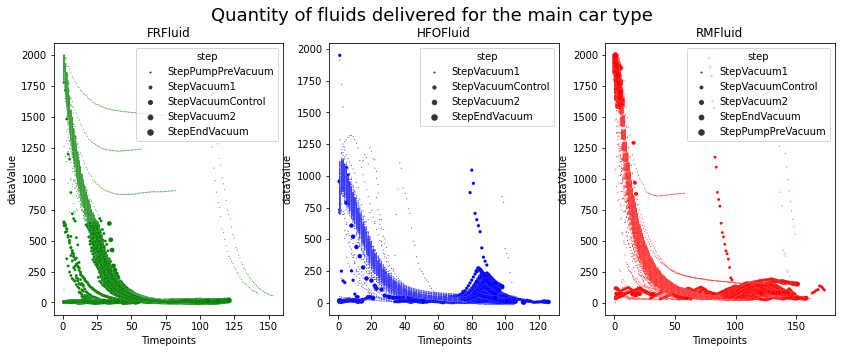

In [60]:
cond = condition[0]
temp = df[df.measurement == 'ActVacuum'].query(cond).copy()
temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby(['pji', 'fluid']).cumcount()+1

plot_fluids(temp, x='rk', y='dataValue', size='step', sizes= (30, 1))
plt.suptitle(f'Quantity of fluids delivered for the main car type', size=18)
plt.show()

In [17]:
# Filter the data on the most representative type of vehicule
vehic_type = top_cars.iloc[0:1,:-1]

most_common_df = pd.merge(vehic_type, df, how='left',
         on= ['body_type','gearbox_type','engine_type','driving_side','hybrid_level'])
most_common_df = most_common_df[['fluid', 'measurement', 'step', 'pji', 'dataValue', 'time']]
most_common_df.head()

# add time-delta feature order by pji > fluid > measurement
most_common_df = most_common_df.sort_values(['fluid', 'measurement', 'time'])
delta = most_common_df.groupby(['pji', 'fluid', 'measurement'])['time'].diff()
delta = delta.fillna(pd.Timedelta(seconds=0))
delta = delta / np.timedelta64(1, 's')
most_common_df['delta'] = delta.values

In [18]:
# remove pji without 3 fluids and 3 measurements
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df, n_fluids=3, n_measure=3)
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]

featured = feature_engineering(most_common_df)

# TTS
train, test = train_test_split(featured, test_size=0.3, random_state=12)

# Normalization pipeline
# Imputer for missing values (due to diff) => input very divergeant value
pipe = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value=-3)
)
pipe.fit(train)
X_train = pipe.transform(train)
X_test = pipe.transform(test)


# Unsupervised anomaly detection algorithm

## Feature engineering

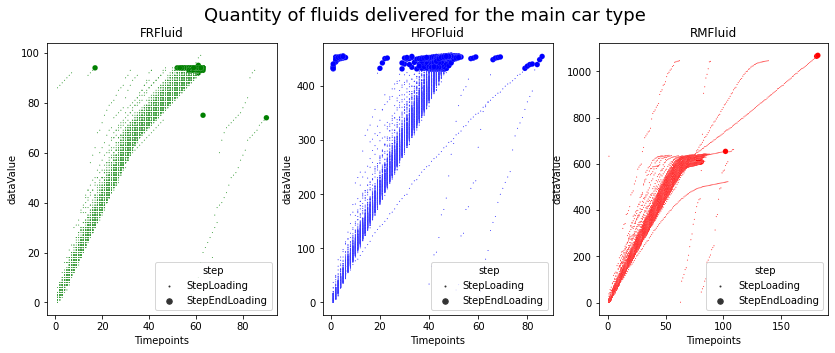

In [56]:
cond = condition[0]
temp = df[df.measurement.isin(filling)].query(cond).copy()
temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby(['pji', 'fluid']).cumcount()+1

plot_fluids(temp, x='rk', y='dataValue', size='step', sizes= (30, 1))
plt.suptitle(f'Quantity of fluids delivered for the main car type', size=18);

**Example of elements selected for the analysis:**
- Values at the end of each measurement
- Slope values during the process
- Interval between two data points 
- Number of data points

## First exploration using a Nearest Neighbor

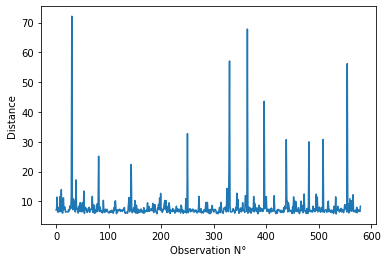

In [19]:
near = NearestNeighbors(n_neighbors=10)
near.fit(X_train)

# distances and indexes of k-neaighbors from model outputs
distances, indexes = near.kneighbors(X_train)# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))
plt.ylabel('Distance')
plt.xlabel('Observation N°');

The algorithm is however not directly adapted for the prediction on unseen data

## Detection using Local Outlier Factor 

In [20]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
lof.fit(X_train)
            
detect = pd.DataFrame(lof.predict(X_test))
detect.columns = ['anomaly']
detect['score'] = lof.score_samples(X_test)
detect.index = test.index
detect = detect[detect.anomaly == -1].sort_values('score')
detect

,anomaly,score
pji,,
2320061,-1,-36.936787
2730079,-1,-15.499131
931371,-1,-9.501739
2440056,-1,-6.515402
640060,-1,-6.235750
950084,-1,-2.734108
1050767,-1,-2.049279
2420082,-1,-2.048725
1620268,-1,-1.864474


**Note:** This algorithm was preferred compared to an Isolation Forest (fewer detections) or a One Class SVM (Too many detections)

## Typical anomaly example

Missing data during one of the phases or for one of the fluid:

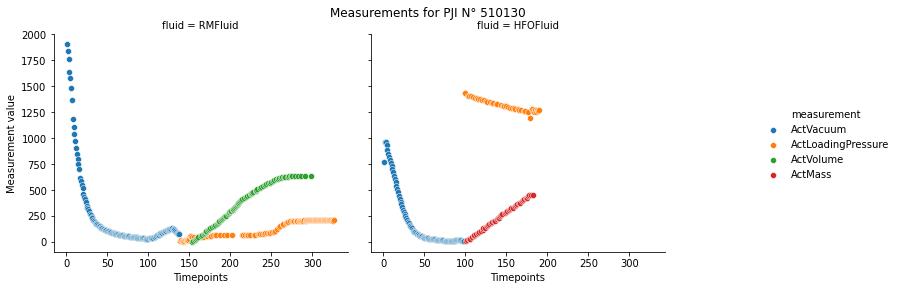

In [21]:
plot_all_fluid(df, bad_pji[0]);

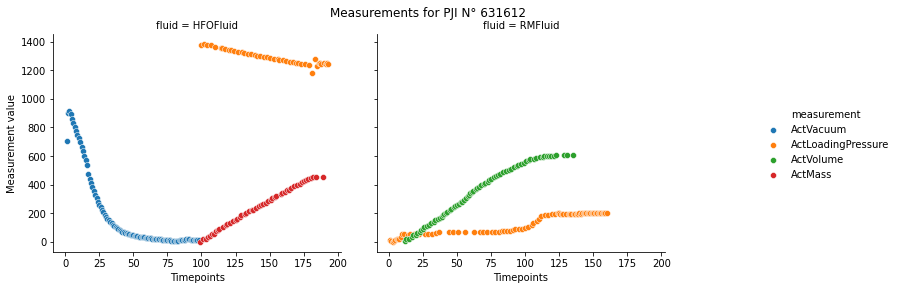

In [22]:
plot_all_fluid(df, bad_pji[2]);

Examples detected by the LOF algorithm:

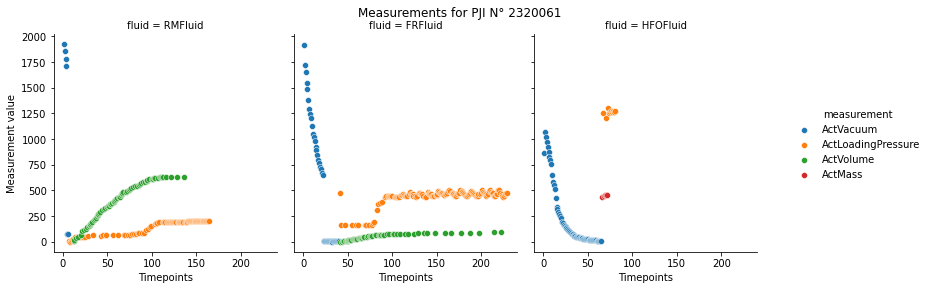

In [24]:
plot_all_fluid(df, detect.index.to_list()[0]);

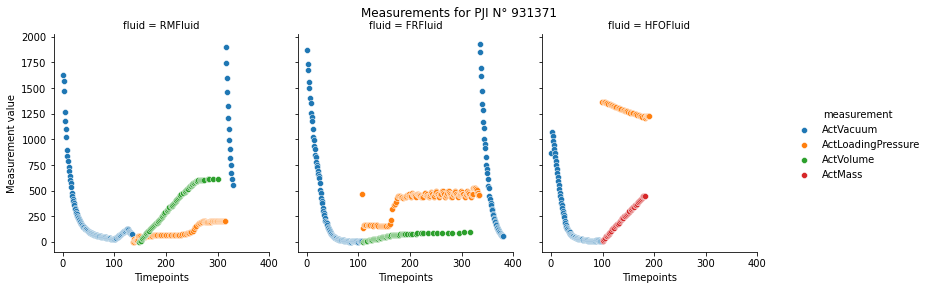

In [25]:
plot_all_fluid(df, detect.index.to_list()[2]);

## Dealing with False Negative and False Positive

- Since false negatives has 10 times the cost of false positives
- Currently the algorithm identify as anomalies ~10 vehicles (i.e. 4% of test data)

- Assuming that currently the False Positives represent ~ 50% of the detection

- It is possible to increase the `contamination` parameter to ~ 0.15
- Should triple the amount of detections to ~12%

- Even in the worst case scenario (only new false positives) the final ratio would approximate $\frac{TP}{FP} ≈ 1/6$

# Case study of the Renault Traffic III

In [26]:
# Train DF
df = pd.read_csv('../data/train_df_LHA.csv',index_col='Unnamed: 0' )
filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

working_df = datetime_reshaping(df)
working_df

# Test DF
test = pd.read_csv('../data/inference_df_LHA.csv', index_col='Unnamed: 0')
test = test.dropna() # Last line contains only na but that's the only one
test.head()
test_reshaped = datetime_reshaping(test)
test_reshaped.head()

# Computation on the train set, prediction on the test set
anomaly = AnomalyDetection(working_df)
anomaly.filter_preprocess_train_data()
anomaly.fit_on_train()
anomaly.filter_preprocess_test_data(test_reshaped)
results = anomaly.return_predictions()

In [27]:
detections = results[ results.anomaly == True].sort_values('score').pji
detections

27    430051.0
54    410339.0
29    430083.0
2     550279.0
55    420147.0
Name: pji, dtype: float64

## Training on the train_df_lha.csv

Small adaptations were required, two elements were removed from the detection algorithm:

- HFOFluid is not used for this type of car
- ActVacuum Phase was intentionally left out, since in the training dataset, it is missing for a large part of the samples 

**Example of filling process for one of the fluid in the training set:**

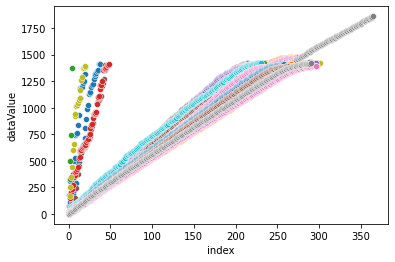

In [28]:
for num in working_df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActVolume')

In [29]:
anomaly.X_test

array([[ 1.05937544,  0.31432985,  0.26020523, ...,  0.00886408,
        -0.31008684,  0.31008684],
       [-0.14762677,  0.31432985,  0.26020523, ..., -0.05632978,
        -0.31008684,  0.31008684],
       [-0.07904709, -0.46749422,  0.22324149, ..., -0.00743439,
        -0.31008684,  0.31008684],
       ...,
       [ 1.03194357,  0.50978587,  0.27868709, ...,  0.02516254,
        -0.31008684,  0.31008684],
       [ 0.18155566,  0.50978587,  0.27868709, ..., -0.38229909,
        -0.31008684,  0.31008684],
       [ 0.27756719,  0.50978587,  0.23248243, ...,  0.00886408,
        -0.31008684,  0.31008684]])

In [30]:
anomaly.filter_preprocess_test_data(working_df)
results_on_train = anomaly.return_predictions()
anomaly_train = results_on_train[results_on_train.anomaly == True].sort_values('score').pji


**Examples of anomalies in the train set:**

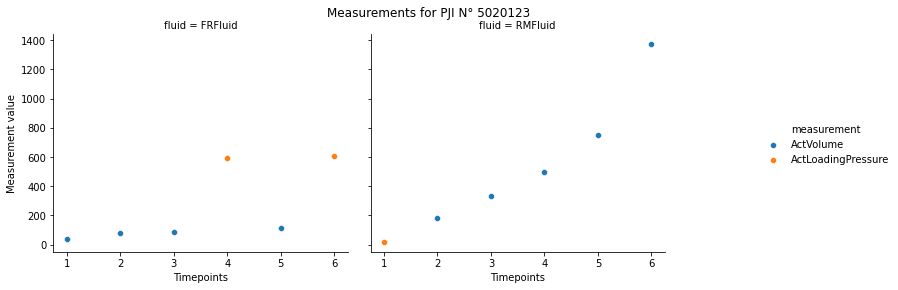

In [31]:
plot_all_fluid(df, anomaly_train.values[0]);

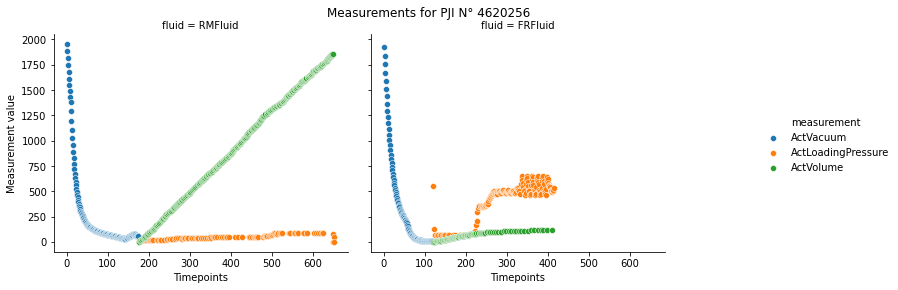

In [32]:
plot_all_fluid(df, anomaly_train.values[1]);

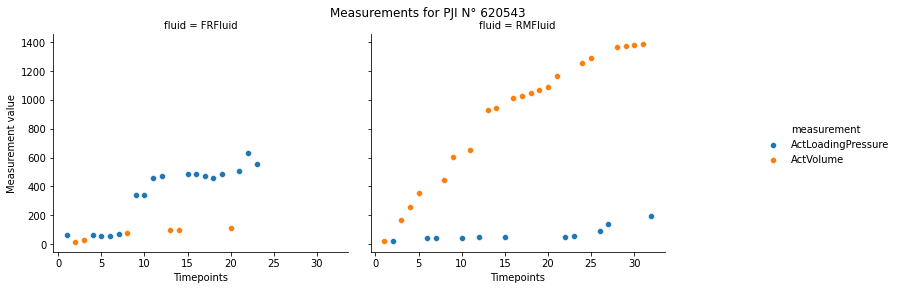

In [33]:
plot_all_fluid(df, anomaly_train.values[2]);

## Anomaly search in the inference dataset

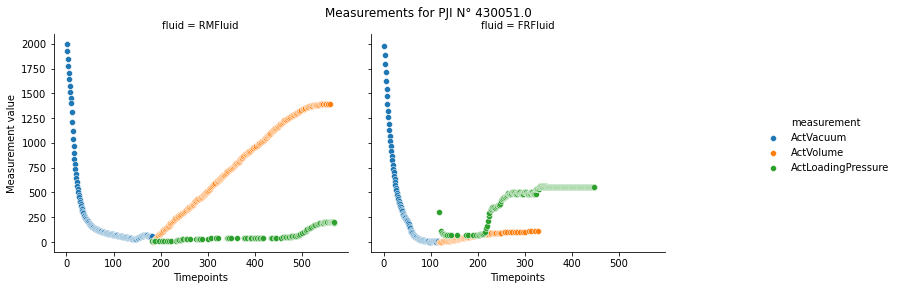

In [34]:
plot_all_fluid(test, detections.values[0]);

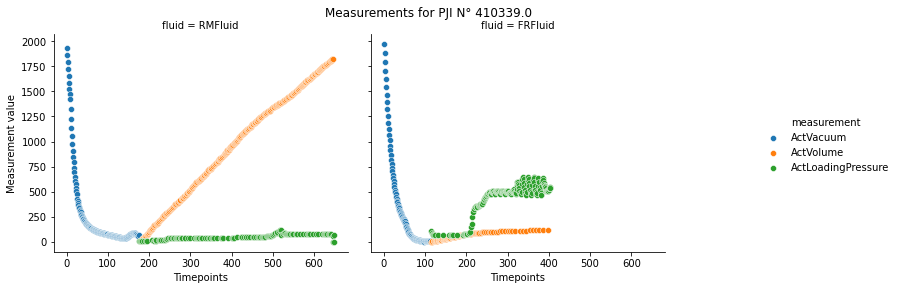

In [35]:
plot_all_fluid(test, detections.values[1]);

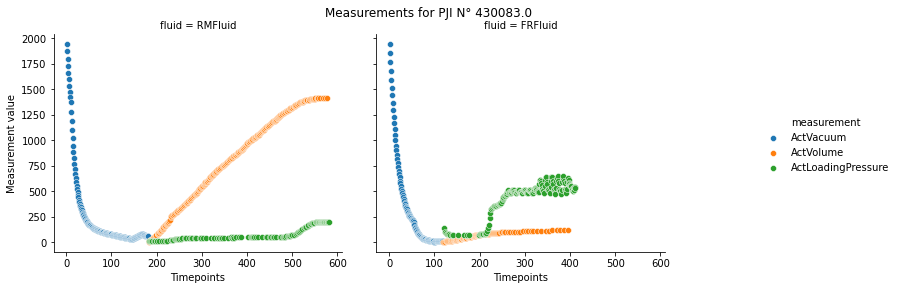

In [36]:
plot_all_fluid(test, detections.values[2]);

The current model does not detect anything particular in the test dataset beyond a few sparse anomalies, and if there is a specific pattern to identify this algorithm would have missed it.

## Post analysis of the test dataset

**Do you notice something happening starting on Jan-29?** 

**How would you react to this in a production environment?**




Increasing the `contamination` parameter increased the number of detections, however it is difficult to highlight a particular trend.

The number of anomalies seems to increase as time passes which may indicate a progressive equipment wear off.

Changing the model to an isolation forest yield similar results

# Conclusion

- Current model classifies about 10% of the production as an anomaly

- Based on production returns, it is possible to adjust the sensibility of the detection

- Perspective to improve the model by looking at a sequence of consecutive pji and estimate a percentage of failures to account for some of the context information.